In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Jan 27 16:54:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [5]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_rand_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [7]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [8]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [10]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_ze2zq_rand/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0
-rw-rw-r-- 1 scpark scpark 0  1월 27 16:55 events.out.tfevents.1706342111.GPUSVR11


In [11]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [12]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [13]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [14]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [15]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

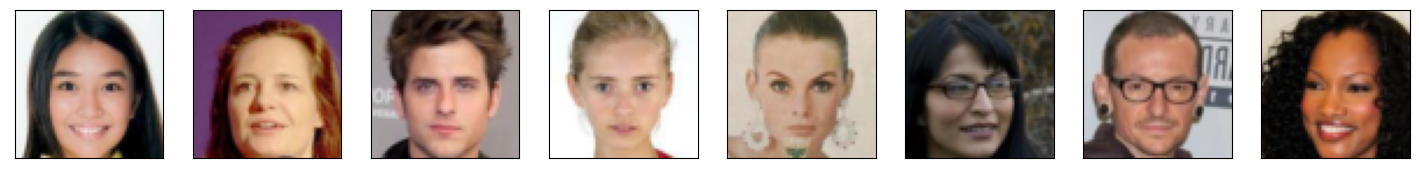

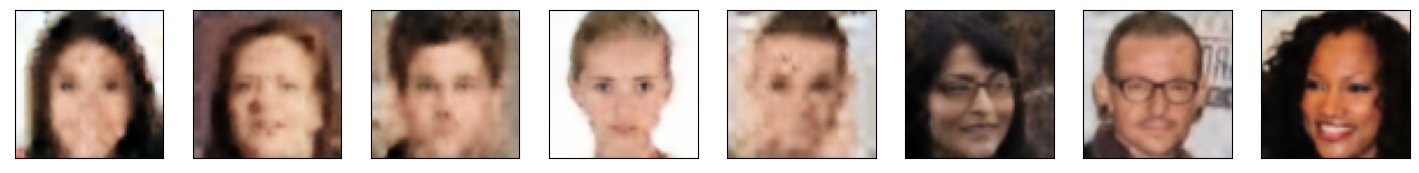

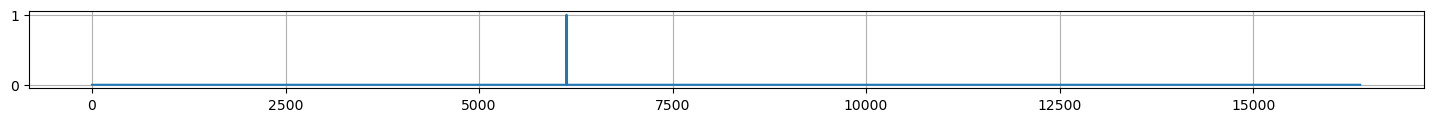

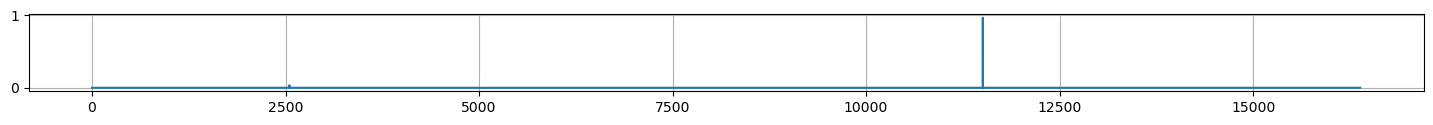

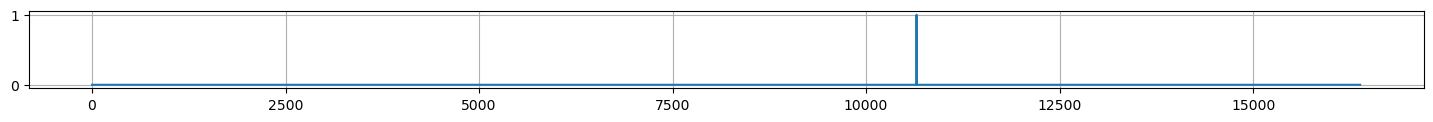

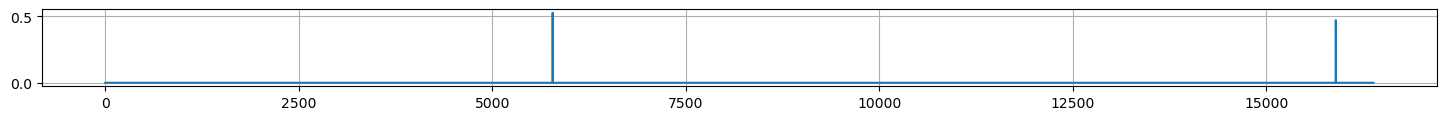

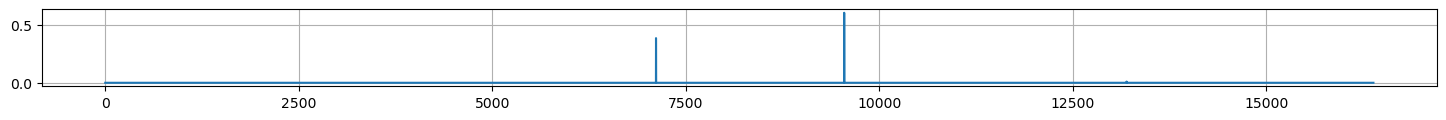

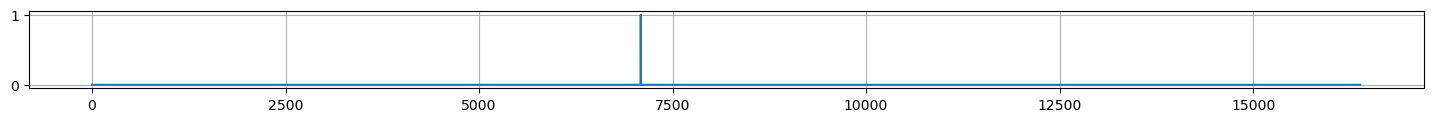

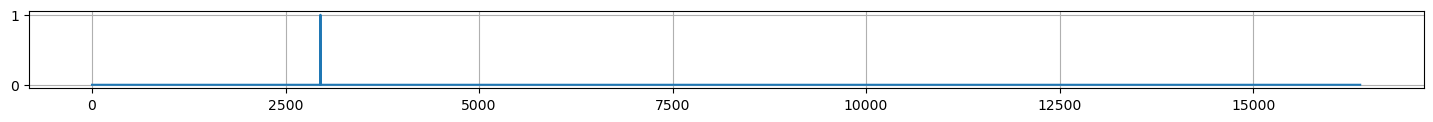

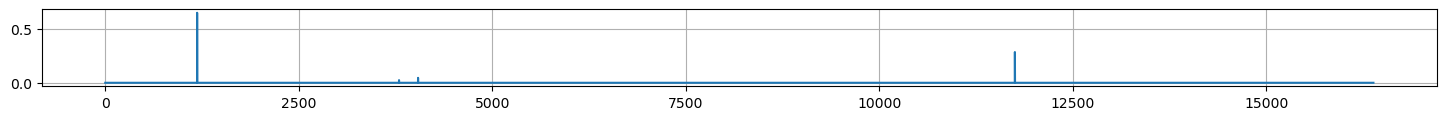

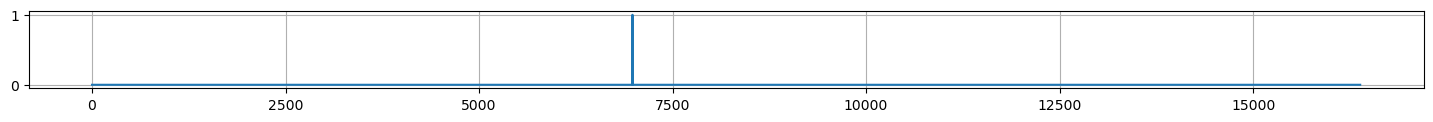

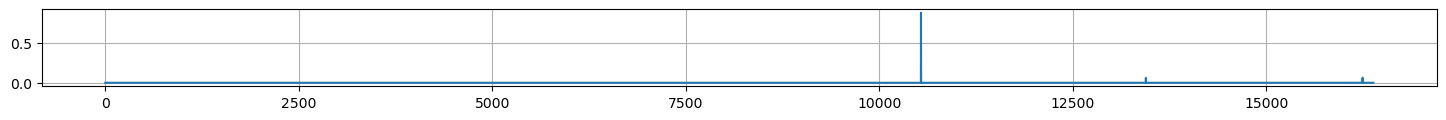

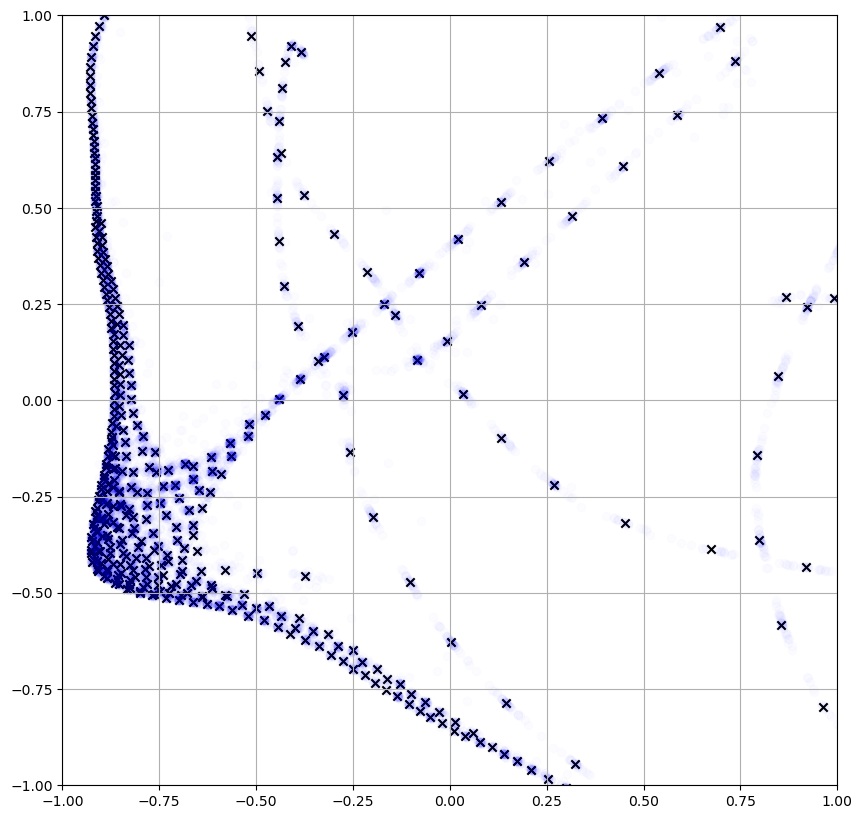

1
lse_loss -339.1836853027344
commit_loss 8.900790999177843e-05
recon_loss 0.006046797148883343
2
lse_loss -386.7928466796875
commit_loss 8.637593418825418e-05
recon_loss 0.005390937440097332
3
lse_loss -376.18017578125
commit_loss 9.306969150202349e-05
recon_loss 0.004771808162331581
4
lse_loss -372.5467834472656
commit_loss 9.092286927625537e-05
recon_loss 0.005055670626461506
5
lse_loss -392.4179992675781
commit_loss 8.559842535760254e-05
recon_loss 0.004415735602378845
6
lse_loss -380.6492614746094
commit_loss 8.919832180254161e-05
recon_loss 0.0035812254063785076
7
lse_loss -384.26458740234375
commit_loss 8.19521228550002e-05
recon_loss 0.003888043574988842
8
lse_loss -397.1031494140625
commit_loss 8.726945088710636e-05
recon_loss 0.004235479980707169
9
lse_loss -398.5041809082031
commit_loss 8.01807182142511e-05
recon_loss 0.003165498375892639
10
lse_loss -394.75750732421875
commit_loss 8.72295131557621e-05
recon_loss 0.0036833088379353285
11
lse_loss -376.91375732421875
commit_l

86
lse_loss -383.7742919921875
commit_loss 7.855120929889381e-05
recon_loss 0.002628125250339508
87
lse_loss -397.1319885253906
commit_loss 8.668114605825394e-05
recon_loss 0.0026631520595401525
88
lse_loss -397.8824157714844
commit_loss 8.806676487438381e-05
recon_loss 0.0027800272218883038
89
lse_loss -388.5455017089844
commit_loss 8.334357698913664e-05
recon_loss 0.00244577182456851
90
lse_loss -398.7635803222656
commit_loss 8.012461330508813e-05
recon_loss 0.0025968309491872787
91
lse_loss -394.1185607910156
commit_loss 8.196687849704176e-05
recon_loss 0.0027126807253807783
92
lse_loss -388.560791015625
commit_loss 8.868436270859092e-05
recon_loss 0.0025828643701970577
93
lse_loss -387.4681396484375
commit_loss 8.697996963746846e-05
recon_loss 0.0031701792031526566
94
lse_loss -394.22027587890625
commit_loss 9.110162500292063e-05
recon_loss 0.002646971959620714
95
lse_loss -393.66595458984375
commit_loss 8.675917342770845e-05
recon_loss 0.0027644129004329443
96
lse_loss -392.128326

171
lse_loss -391.2066955566406
commit_loss 8.584372699260712e-05
recon_loss 0.002474419539794326
172
lse_loss -389.3268127441406
commit_loss 8.849069126881659e-05
recon_loss 0.0025068148970603943
173
lse_loss -393.9461975097656
commit_loss 8.725396764930338e-05
recon_loss 0.0027598466258496046
174
lse_loss -391.4009094238281
commit_loss 9.434224921278656e-05
recon_loss 0.002586127258837223
175
lse_loss -393.0085754394531
commit_loss 8.168568456312642e-05
recon_loss 0.0026386980898678303
176
lse_loss -391.2878723144531
commit_loss 8.565148164052516e-05
recon_loss 0.002547040581703186
177
lse_loss -389.9532775878906
commit_loss 8.697203156771138e-05
recon_loss 0.0026457682251930237
178
lse_loss -394.7798767089844
commit_loss 8.893281483324245e-05
recon_loss 0.0017352316062897444
179
lse_loss -390.4182434082031
commit_loss 8.648632501717657e-05
recon_loss 0.00224887253716588
180
lse_loss -392.8684387207031
commit_loss 8.682550105731934e-05
recon_loss 0.0022621862590312958
181
lse_loss -3

256
lse_loss -388.0518493652344
commit_loss 8.959846309153363e-05
recon_loss 0.002625171560794115
257
lse_loss -391.681884765625
commit_loss 8.894164784578606e-05
recon_loss 0.0035199697595089674
258
lse_loss -389.91119384765625
commit_loss 8.714861178305e-05
recon_loss 0.0024593467824161053
259
lse_loss -386.569091796875
commit_loss 8.603454625699669e-05
recon_loss 0.0022460748441517353
260
lse_loss -389.5313720703125
commit_loss 9.186608804157004e-05
recon_loss 0.0027871988713741302
261
lse_loss -389.1242370605469
commit_loss 8.767675899434835e-05
recon_loss 0.002818417502567172
262
lse_loss -387.8870544433594
commit_loss 8.909087773645297e-05
recon_loss 0.002332474570721388
263
lse_loss -391.4264831542969
commit_loss 8.508410246577114e-05
recon_loss 0.0028447150252759457
264
lse_loss -387.060546875
commit_loss 9.526542271487415e-05
recon_loss 0.002617279067635536
265
lse_loss -395.7699890136719
commit_loss 8.260838512796909e-05
recon_loss 0.0021616783924400806
266
lse_loss -365.5910

341
lse_loss -386.5751647949219
commit_loss 8.939120743889362e-05
recon_loss 0.002047190209850669
342
lse_loss -389.6908874511719
commit_loss 8.475247886963189e-05
recon_loss 0.0022580435033887625
343
lse_loss -385.83154296875
commit_loss 9.231268631992862e-05
recon_loss 0.0022770664654672146
344
lse_loss -390.3077697753906
commit_loss 8.742573845665902e-05
recon_loss 0.002139532007277012
345
lse_loss -370.7407531738281
commit_loss 8.438834629487246e-05
recon_loss 0.002176489681005478
346
lse_loss -387.3791809082031
commit_loss 8.995438838610426e-05
recon_loss 0.0019273854559287429
347
lse_loss -387.9026794433594
commit_loss 8.671807881910354e-05
recon_loss 0.0020188395865261555
348
lse_loss -389.9317321777344
commit_loss 8.240516763180494e-05
recon_loss 0.0020610312931239605
349
lse_loss -373.11163330078125
commit_loss 8.479050302412361e-05
recon_loss 0.0024480458814650774
350
lse_loss -386.6532287597656
commit_loss 9.355123620480299e-05
recon_loss 0.0021406055893749
351
lse_loss -390

426
lse_loss -378.7513732910156
commit_loss 0.00010042796930065379
recon_loss 0.002489544451236725
427
lse_loss -383.9701843261719
commit_loss 9.425261669093743e-05
recon_loss 0.002396953757852316
428
lse_loss -382.419189453125
commit_loss 9.702965326141566e-05
recon_loss 0.0022603259421885014
429
lse_loss -383.9374694824219
commit_loss 9.289344598073512e-05
recon_loss 0.0020940089598298073
430
lse_loss -371.1302795410156
commit_loss 9.127093653660268e-05
recon_loss 0.0019255392253398895
431
lse_loss -374.34478759765625
commit_loss 8.900405373424292e-05
recon_loss 0.0020084725692868233
432
lse_loss -380.28924560546875
commit_loss 8.922761480789632e-05
recon_loss 0.00196717563085258
433
lse_loss -365.0115051269531
commit_loss 9.623625373933464e-05
recon_loss 0.002384919673204422
434
lse_loss -382.1080322265625
commit_loss 9.057564602699131e-05
recon_loss 0.0018255633767694235
435
lse_loss -375.8218688964844
commit_loss 9.416131797479466e-05
recon_loss 0.0018520033918321133
436
lse_loss 

511
lse_loss -386.2288513183594
commit_loss 9.888058411888778e-05
recon_loss 0.0021053205709904432
512
lse_loss -378.06451416015625
commit_loss 9.881592995952815e-05
recon_loss 0.002102064900100231
513
lse_loss -381.4267272949219
commit_loss 9.949866944225505e-05
recon_loss 0.002028624527156353
514
lse_loss -380.49945068359375
commit_loss 9.890367073239759e-05
recon_loss 0.002138993237167597
515
lse_loss -384.4697265625
commit_loss 0.00010153771290788427
recon_loss 0.0018044218886643648
516
lse_loss -386.66583251953125
commit_loss 9.596254676580429e-05
recon_loss 0.0017771985149011016
517
lse_loss -374.6539611816406
commit_loss 9.949169179890305e-05
recon_loss 0.0018805002328008413
518
lse_loss -381.57757568359375
commit_loss 9.94875153992325e-05
recon_loss 0.0020957961678504944
519
lse_loss -382.3210144042969
commit_loss 0.00010626536095514894
recon_loss 0.001997777260839939
520
lse_loss -374.60748291015625
commit_loss 0.00010342536552343518
recon_loss 0.0021214180160313845
521
lse_lo

596
lse_loss -376.4141540527344
commit_loss 9.328308806288987e-05
recon_loss 0.0021314513869583607
597
lse_loss -374.3048400878906
commit_loss 0.0001018660404952243
recon_loss 0.0022132042795419693
598
lse_loss -375.9815673828125
commit_loss 0.00010696528624976054
recon_loss 0.00224724761210382
599
lse_loss -377.2659606933594
commit_loss 9.306987340096384e-05
recon_loss 0.002116803778335452
600
lse_loss -374.7767639160156
commit_loss 9.951269021257758e-05
recon_loss 0.002163173630833626
601
lse_loss -377.2423095703125
commit_loss 9.601063356967643e-05
recon_loss 0.0017996979877352715
602
lse_loss -378.6893615722656
commit_loss 0.00010432378621771932
recon_loss 0.0022377315908670425
603
lse_loss -379.43682861328125
commit_loss 0.00010277872206643224
recon_loss 0.002178031485527754
604
lse_loss -376.5137634277344
commit_loss 9.500676242168993e-05
recon_loss 0.0020129657350480556
605
lse_loss -379.7381896972656
commit_loss 9.802357817534357e-05
recon_loss 0.002144033554941416
606
lse_loss

681
lse_loss -373.1313781738281
commit_loss 9.571712143952027e-05
recon_loss 0.001731475698761642
682
lse_loss -380.4191589355469
commit_loss 0.00010869145626202226
recon_loss 0.002080294070765376
683
lse_loss -366.7458801269531
commit_loss 9.601331839803606e-05
recon_loss 0.002359798178076744
684
lse_loss -374.4574279785156
commit_loss 9.616344323148951e-05
recon_loss 0.0021437618415802717
685
lse_loss -368.8618469238281
commit_loss 0.00010170403402298689
recon_loss 0.00215081381611526
686
lse_loss -376.94561767578125
commit_loss 9.965458593796939e-05
recon_loss 0.0021125981584191322
687
lse_loss -373.51092529296875
commit_loss 0.00010079704225063324
recon_loss 0.002236270811408758
688
lse_loss -370.0426330566406
commit_loss 9.469297219766304e-05
recon_loss 0.001986148301512003
689
lse_loss -362.87261962890625
commit_loss 0.00010102209489559755
recon_loss 0.001958706183359027
690
lse_loss -371.1202697753906
commit_loss 9.830967610469088e-05
recon_loss 0.0019029140239581466
691
lse_los

766
lse_loss -378.6131896972656
commit_loss 0.00010107165871886536
recon_loss 0.0017028257716447115
767
lse_loss -376.1495056152344
commit_loss 0.0001027111429721117
recon_loss 0.0022661066614091396
768
lse_loss -379.7844543457031
commit_loss 0.00010503140947548673
recon_loss 0.002321731299161911
769
lse_loss -381.1159362792969
commit_loss 0.00010575916530797258
recon_loss 0.002026099245995283
770
lse_loss -377.7883605957031
commit_loss 0.00010750163346529007
recon_loss 0.0020975321531295776
771
lse_loss -372.5515441894531
commit_loss 0.00011700126924552023
recon_loss 0.0019315717509016395
772
lse_loss -376.83056640625
commit_loss 0.00010213704081252217
recon_loss 0.0017984909936785698
773
lse_loss -382.6699523925781
commit_loss 9.915650298353285e-05
recon_loss 0.001740712090395391
774
lse_loss -378.6137390136719
commit_loss 0.00010096236655954272
recon_loss 0.0020123515278100967
775
lse_loss -381.0335998535156
commit_loss 0.00011680370516842231
recon_loss 0.002144724829122424
776
lse_

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 100*1000)
            data = model(data, latent_temp=1, quant_temp=quant_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [12]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


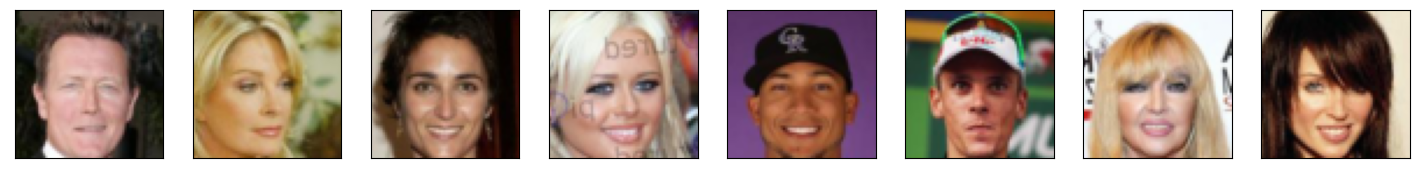

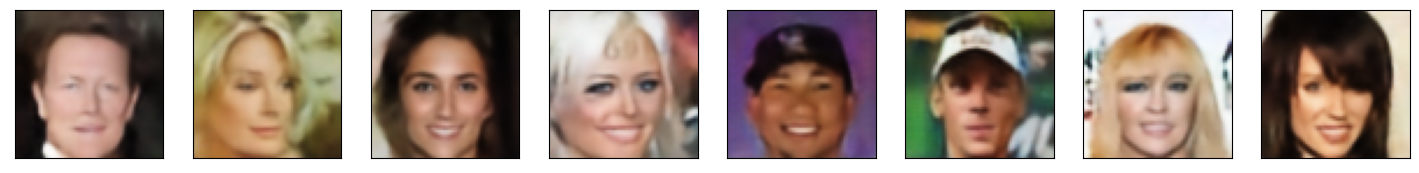

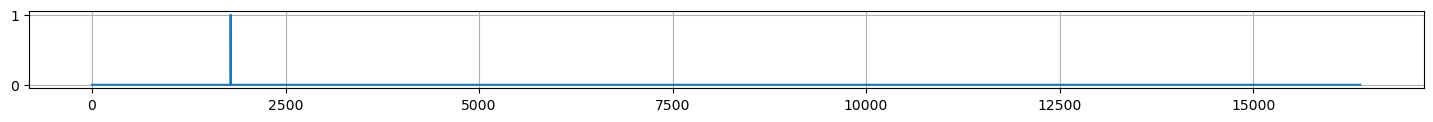

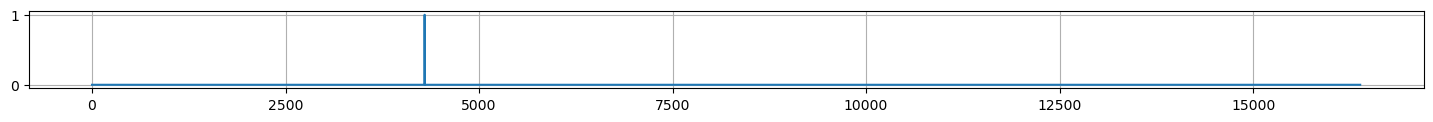

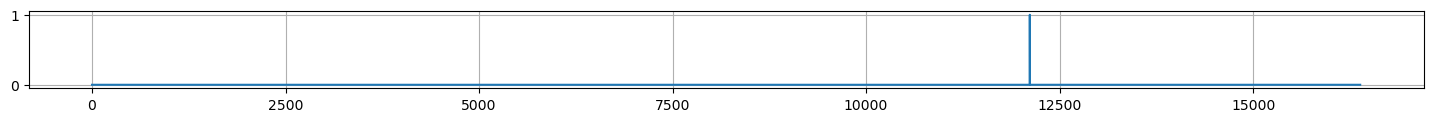

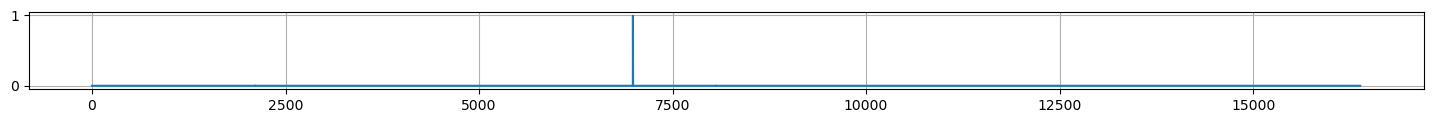

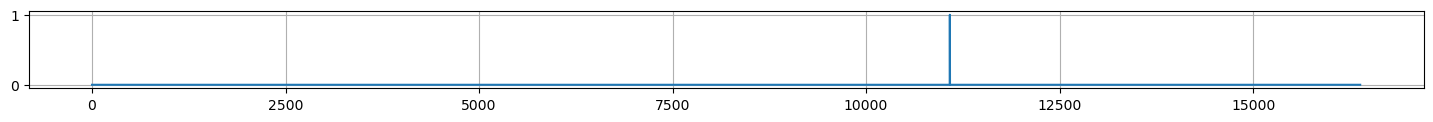

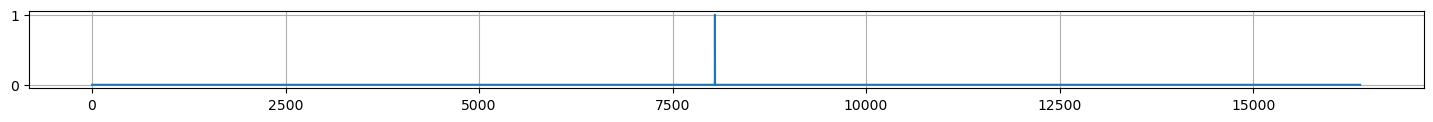

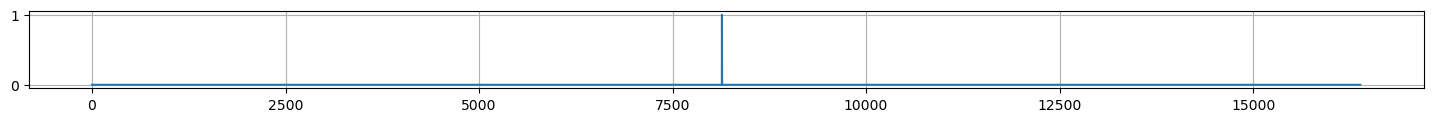

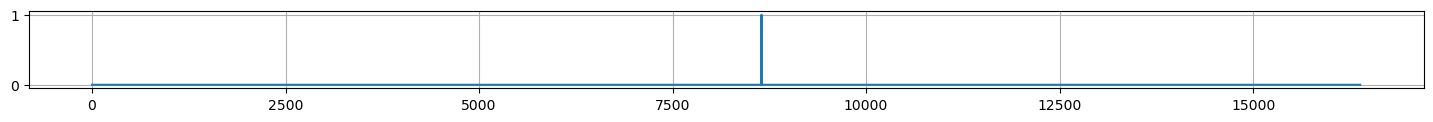

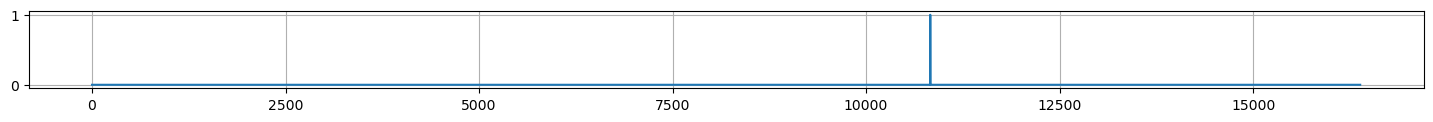

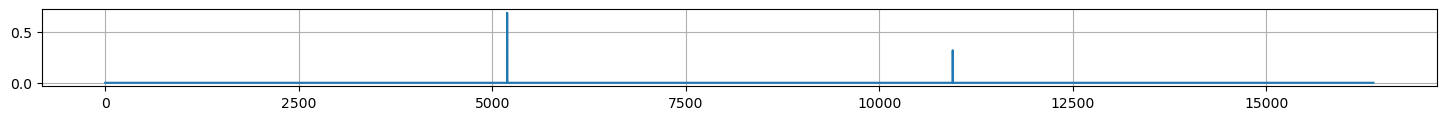

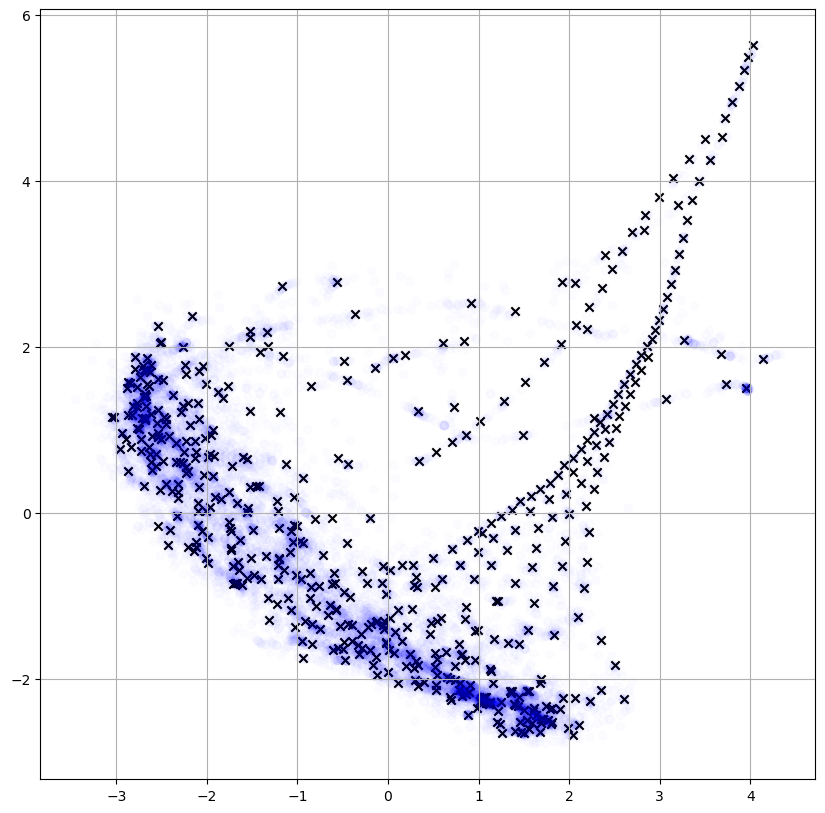

In [13]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 